# Validating the binary implementation of LBMeX

1. [Coexistence curve](#Obtaining-the-Coexistence-Curve)
    * [Interface width](#Interface-width-as-a-function-of-parameters)
2. [Surface Tension](#Surface-Tension)

In [178]:
import numpy as np
import matplotlib.pyplot as plt
import yt
from yt.frontends.boxlib.data_structures import AMReXDataset
yt.set_log_level(50)
from matplotlib import animation
from IPython.display import HTML
import os
from subprocess import Popen, PIPE
import mpi4py
import shlex
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
import glob

### Animation utilities

Below functions help to plot data as animations easily. For `cmap_ani`, the input data is a 3D array with the time series as the first dimension and the 2D array to plot as dimensions 2 and 3. In a schematic, it would look like this $(t, x, y)$ where t is the time series and x and y is the 2D data.

In [179]:
def cmap_ani(data, interval=50):
    def init():
        img.set_data(data[0])
        return (img,)

    def update(i):
        img.set_data(data[i])
        return (img,)

    fig, ax = plt.subplots()
    img = ax.imshow(data[0], cmap = 'bwr', vmin = np.amin(data), vmax = np.amax(data))
#     plt.imshow(rho, vmin = rho0-0.1, vmax = rho0+0.1, cmap = 'bwr')
    fig.colorbar(img, ax = ax, orientation="horizontal", pad=0.2)
    ani = animation.FuncAnimation(fig, update, frames=len(data), init_func=init, interval=interval, blit=True)
    plt.close()
    return ani

def plot_ani(x, y, interval = 50, titles = None):
    fig, ax = plt.subplots()
    ln, = ax.plot(x[0], y[0])
    ax.set(ylim = (np.amin(y), np.amax(y)), xlim = (np.amin(x), np.amax(x)))
    if type(titles) != None:
        title = ax.text(0.9,0.85, "", bbox={'facecolor':'w', 'alpha':0.5, 'pad':5}, transform=ax.transAxes, ha="center")

    def init():
        if type(titles) != None:
            title.set_text(titles[0])
        ln.set_data(x[0], y[0])
        return ln,

    def update(i):
        if type(titles) != None:
            title.set_text(titles[i])
        ln.set_data(x[i], y[i])
        return ln,

    ani = animation.FuncAnimation(fig, update, frames= len(x), init_func=init, interval=interval, blit=True)
    plt.close()
    return ani

### Calcualting interface width

The slope of the profile can be defined as $ m = \frac{dC}{dx}$ which can be rewritten in a more general sense as $ \Delta x = \frac{ \Delta C}{m}$. 

The gradient, $m$, can then be rewritten in the form, $\frac{dC}{dx}$. In this case, as we know that the interface will be at location $x = 0.5L$ where L is the box length, the interface width can then be expressed as, 

$$ d_{int}  = \frac{\Delta C}{\frac{dC}{dx}|_{x = L/2}}$$

Where $d_{int}$ is the interface width, $\Delta C = \phi_{max} - \phi_{min}$ where $\phi$ is the order parameter. $\frac{dC}{dx}|_{x = L/2}$ can be obtained using a function like `np.gradient`

In [180]:
def interface_width(phi, tol = 2*10**-1):
    phi_min = np.amin(phi)
    phi_max = np.amax(phi)
    max_grad = np.amax(np.abs(np.gradient(phi)))
    d = (phi_max - phi_min)/max_grad
    return d

### Surface tension calculation 

The bulk free energy of the system, $\psi$ is, 

$$ \psi(\Delta n, n, T) = \frac{\lambda}{4}n(1 - (\frac{\Delta n}{n})^2 ) - Tn + \frac{T}{2}(n + \Delta n)ln(\frac{n + \Delta n}{2}) + \frac{T}{2}(n - \Delta n)ln(\frac{n + \Delta n}{2})$$

Where $\lambda$ is the strength of the interaction and $T$ is a temperature like parameter. $\Delta n$ is the density difference towards which the sytem phase separates. To obtain the chemical potential, the derivate of $\psi$ is taken with respect to $n$ to obtain, 

$$ \Delta \mu(\Delta n, n, T) = - \frac{\lambda \Delta n}{2 n} + \frac{T}{2} ln(\frac{1 + \frac{\Delta n}{n} }{1 - \frac{\Delta n}{n} }) - \kappa \nabla^2 (\Delta n)$$ 

In [181]:
import scipy
from scipy.optimize import fsolve
from scipy.integrate import solve_bvp

rho = 1

def coexistence(T=0.5, Lambda=1.1):
    phi0 = fsolve(lambda phi: -Lambda/2*phi/rho + T/2*np.log((rho+phi)/(rho-phi)), x0=0.5)
    return phi0[0]

def profile(kappa, T=0.5, Lambda=1.1, L = 64):

    def fun(x, y):
        phi, psi = y
        dphi = psi
        dpsi = - Lambda/(2*kappa)*phi/rho + T/(2*kappa)*np.log((rho+phi)/(rho-phi))
        return np.vstack([dphi, dpsi])

    def bc(ya, yb):
        return np.array([ya[0]+phi0,yb[0]-phi0]).reshape(2,)

    x = np.linspace(-L//2, L//2-1, L)+0.5
    phi0 = coexistence(T, Lambda)
    y0 = np.vstack([phi0*np.tanh(x), phi0*(1-np.tanh(x)**2)])

    res = solve_bvp(fun, bc, x, y0)
    
    return x, res.sol

def free_energy(rho, phi, kappa, T=0.5, Lambda=1.1):
    C1 = (rho+phi)/2
    C2 = (rho-phi)/2
    f = kappa/2*np.gradient(rho)**2 + kappa/2*np.gradient(phi)**2 \
        + Lambda/4*rho*(1-phi**2/rho**2) \
        - T*rho + T*C1*np.log(C1) + T*C2*np.log(C2)
    return f

def surface_tension(kappa, T=0.5, Lambda=1.1):
    x, sol = profile(kappa)
    phi = sol(x)[0]
    f = free_energy(np.full_like(x,1), phi, kappa, T, Lambda)
    sigma = (f-f[-1]).sum()
    return sigma

### Radius of a droplet

In [223]:
def droplet_radius(ds_yt):
    ad = ds_yt.all_data()
    
    center = ds_yt.r[0.5,0.5,0.5]
    corner = ds_yt.r[0.0,0.0,0.0]
    
    rho_d = 0.5*(center['rho']+center['phi'])[0].value
    rho_s = 0.5*(corner['rho']+corner['phi'])[0].value
    
    M = (0.5*(ad['rho']+ad['phi'])-rho_s).sum().value
    r = np.cbrt(3/4/np.pi*M/(rho_d-rho_s))
    return r

## Obtaining the Coexistence Curve

In [152]:
T_s = np.linspace(0.45, 0.6, 11)
nsteps = 20000
nx = 64
plot_int = 400
parent_dir = os.getcwd()

for i, T in enumerate(T_s):
    file_out = parent_dir+ '/T_{0:.3f}'.format(T)
    
    try:
        os.makedirs(file_out)
    except FileExistsError:
        print('folder exists')
    
    os.system('cp main3d.gnu.MPI.ex {0}'.format(file_out))
    os.chdir(file_out)
    print(os.getcwd())
    
    # os.system('mpirun -n 4 ./main3d.gnu.MPI.ex nx={0} nsteps={1} plot_int={2} T={3}'.format(nx, nsteps, plot_int, T))
    input_str = 'mpirun -n 6 ./main3d.gnu.MPI.ex nx={0} nsteps={1} plot_int={2} T={3}'.format(nx, nsteps, plot_int, T)
    
    with open('run.sh', 'w') as f:
        f.write('#!/bin/bash' + '\n')
        f.write(input_str)
    
    os.system('chmod 777 run.sh')
    
    # input_ls = input_str.split()
    # process = Popen(input_ls, stdout=PIPE, stderr=PIPE)
    # stdout, stderr = process.communicate()
    
    # print(input_str)
    os.chdir(parent_dir)
    # print(stdout)

In [4]:
run_script = '''#!/bin/bash

for i in $(find -name "T_*"); 
do
    echo "$i"
    cd ${i}
    ./run.sh
    cd ..
    echo ${PWD}
done
'''

with open('coexistence_script.sh', 'w') as f:
    f.write(run_script)
    
os.system('chmod 777 run.sh')

Go to the folder that points to `parent_dir` variable in the code snippet above and run `./ coexistence_script.sh`. Proceed with the rest of the script after this.

In [4]:
parent_dir = os.getcwd()
T_s = np.linspace(0.45, 0.6, 11)
paths = [parent_dir+ '/T_{0:.3f}'.format(T) for T in T_s]

phi_s = np.zeros((len(paths), 51, 64, 64, 64))

for i, path in enumerate(paths):
    ts = yt.load(path + '/plt*')
    # print(i)
    for j, ds in enumerate(ts):
        phi = ds.r['boxlib' , 'phi'].reshape(64, 64, 64)
        phi_s[i, j] = phi
        # print(phi.shape)

In [164]:
# writer = animation.PillowWriter(fps=25)
# timesteps = np.linspace(0, 20000, 51)


# for i in range(0, len(paths)):
#     path = paths[i]
#     T = paths[i].split('/')[-1].split('_')[-1]
#     # print(path, T)
    
#     cmap = cmap_ani(phi_s[i, :, 32, :, :])
    
#     y = phi_s[i, :, 32, :, 32]
#     x = np.zeros(y.shape)
#     x[:] = np.linspace(0, 63, 64)
#     profile = plot_ani(x, y)
    
#     cmap.save(path + "/cmap_T{0}.gif".format(T), dpi=300, writer = writer)
#     profile.save(path + "/profile_T{0}.gif".format(T), dpi=300, writer = writer)

In [8]:
y = phi_s[:, -1, 32, :, 32]
x = np.zeros(y.shape)
x[:] = np.linspace(0, 63, 64)
temperatures = np.array(['T = {0:.3f}'.format(T_s[i]) for i in range(0, len(T_s)) ])
ani = plot_ani(x, y, interval = 500, titles = temperatures)
ani.save(parent_dir + '/last_timestep_compare.gif', dpi = 300, writer = animation.PillowWriter(fps=3))
HTML(ani.to_jshtml())

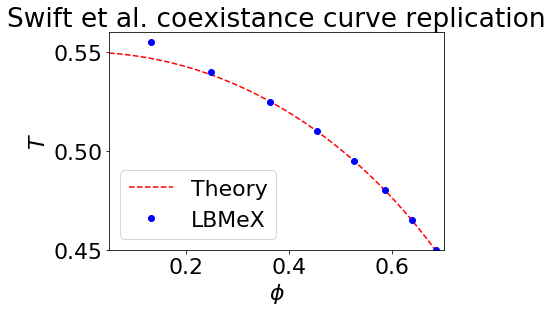

In [9]:
dn_s = np.arange(0.05, 0.7, 0.005)
T_theory = 1.1*dn_s/(np.log((1 + dn_s)/(1 - dn_s)))

plt.plot(dn_s, T_theory, '--r', label = 'Theory')
plt.plot(np.max(phi_s[:, -1, 32, :, 32], axis = -1), T_s, 'bo', label = 'LBMeX')
plt.xlabel(r'$\phi$')
plt.ylabel(r'$T$')
plt.title('Swift et al. coexistance curve replication')
plt.legend()
plt.ylim([min(T_s), 0.56])
plt.xlim([0.05, 0.7])
plt.savefig(parent_dir + '/coexistence_curve.png')

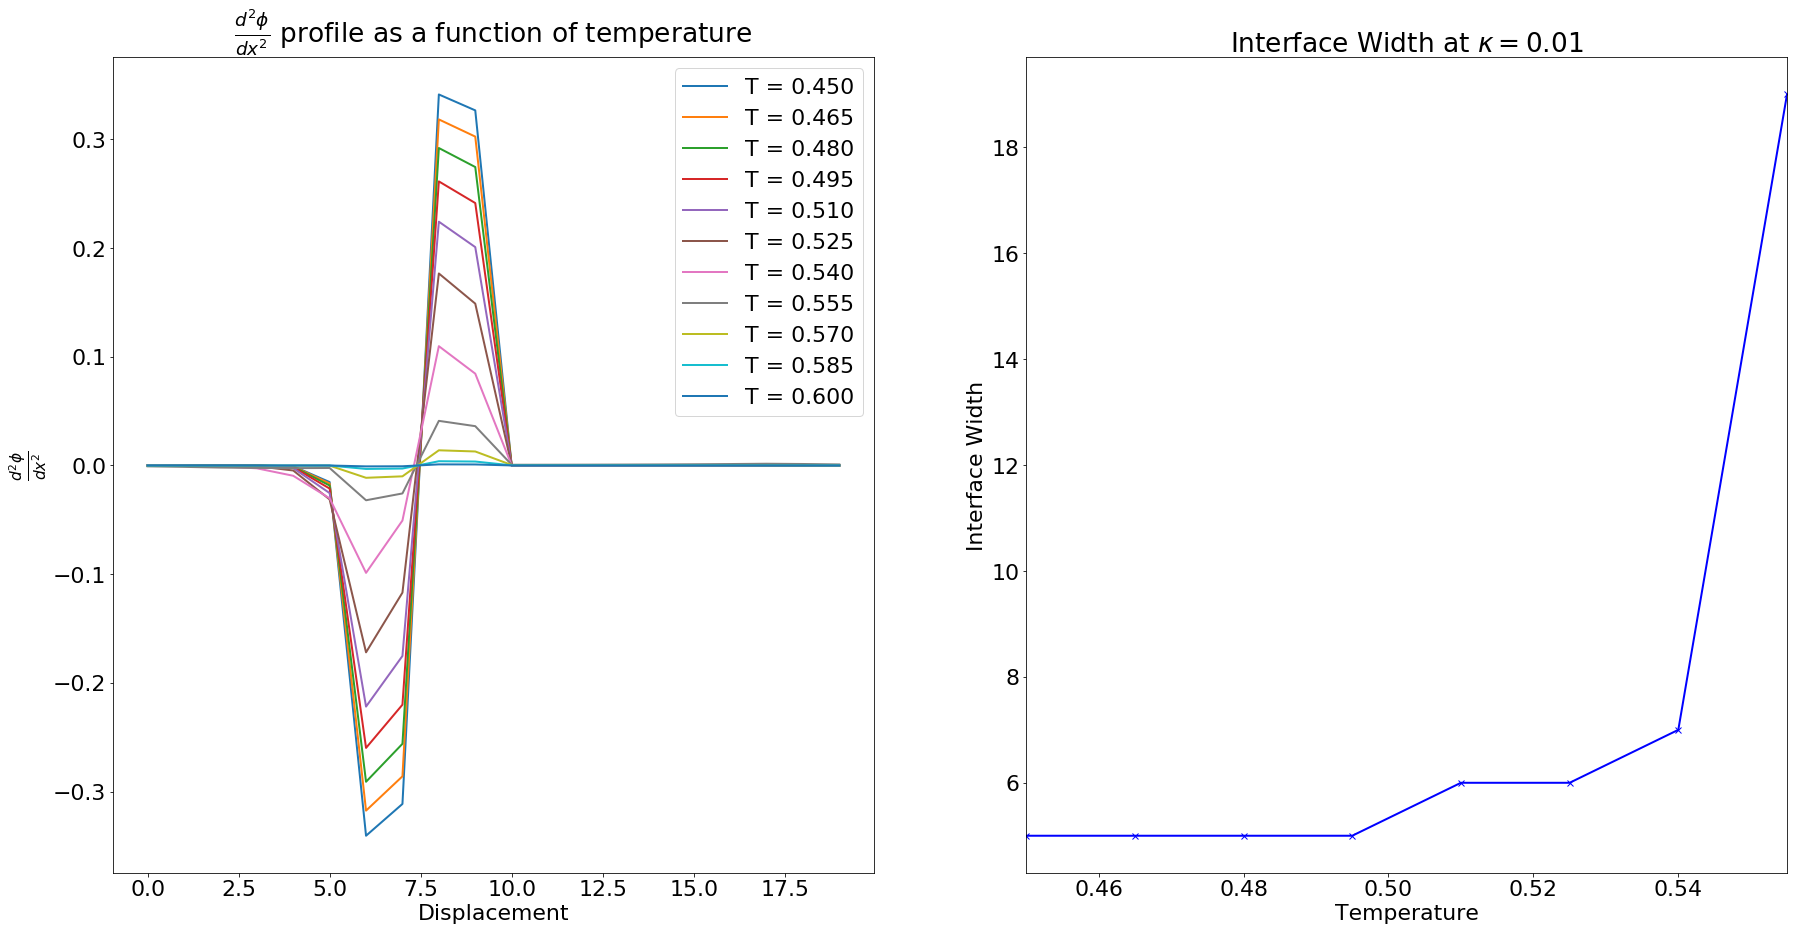

In [11]:
density = phi_s[5, -1, 32, :20, 32]

fig, axs = plt.subplots(1, 2, figsize = (30, 15))
axs = axs.flatten()

temperatures = np.array(['T = {0:.3f}'.format(T_s[i]) for i in range(0, len(T_s)) ])
interface_width = np.zeros(len(temperatures))
for i in range(0, len(paths)):
    density = phi_s[i, -1, 32, :20, 32]
    test = np.gradient(np.gradient(density))
    filtered_test = np.where(abs(test/np.amax(test)) > 10**-2, test, 0)
    interface_width[i] = np.unique(filtered_test).size - 1
    axs[0].plot(test, label = temperatures[i], linewidth = 2)
    axs[0].set(title = r'$\frac{d^2 \phi }{dx^2}$ profile as a function of temperature', xlabel = 'Displacement', ylabel = r'$\frac{d^2 \phi }{dx^2}$')

axs[0].legend()
axs[-1].plot(T_s, interface_width, '-bx', linewidth = 2)
axs[-1].set(title = r'Interface Width at $\kappa = 0.01$', xlabel = 'Temperature', ylabel = 'Interface Width', xlim = (np.amin(T_s), 0.555))
fig.savefig(parent_dir + '/interface_width.png')

### Interface-width-as-a-function-of-parameters

Parameters of interest for this analysis are the temperature of the systen, $T$ and the interaction consistent between fluids, $\kappa$. 

In [133]:
i_w_dir = r'/home/nikhil/Documents/LBMeX/amrex-tutorials/GuidedTutorials/LBM/binary/interface_width'

k_dir = sorted(glob.glob(i_w_dir + '/k*'))
T_dir = sorted(glob.glob(k_dir[0] + '/T*'))
sz = len(sorted(glob.glob(T_dir[0] + '/plt*')))


phi_slices = np.zeros((len(k_dir), len(T_dir), 32))
kappa_ls = np.zeros(len(k_dir))
T_ls = np.zeros(len(T_dir))

for i, head_path in enumerate(k_dir):
    T_dir = sorted(glob.glob(head_path + '/T*'))
    for j, T_path in enumerate(T_dir):
        k = head_path.split('/')[-1].split('_')[-1]
        T = T_path.split('/')[-1].split('_')[-1]
        kappa_ls[i] = k
        T_ls[j] = T
    
        ts = yt.load(T_path + '/plt*')
        
        phi = ts[-1].r[:, 0.5, 0.5]['phi']
        phi_slices[i, j] = phi

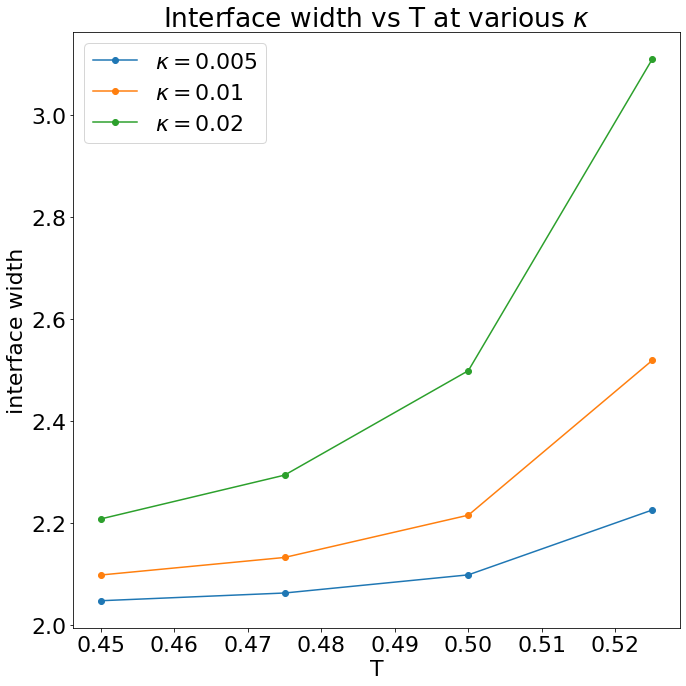

In [184]:
fig, axs = plt.subplots(1, 1, figsize = (10, 10))

for i in range(n[0]):
    temp_list = np.zeros(n[1])
    for j in range(n[1]):
        temp_list[j] = interface_width(phi_slices[i, j], tol = 2*10**-1)

    axs.plot(T_ls, temp_list, '-o', label = r'$\kappa = $' + str(kappa_ls[i]))
axs.set(xlabel = 'T', ylabel = 'interface width', title = r'Interface width vs T at various $\kappa$')
axs.legend()

fig.tight_layout()
fig.savefig(i_w_dir + '/i_w_compare.png')

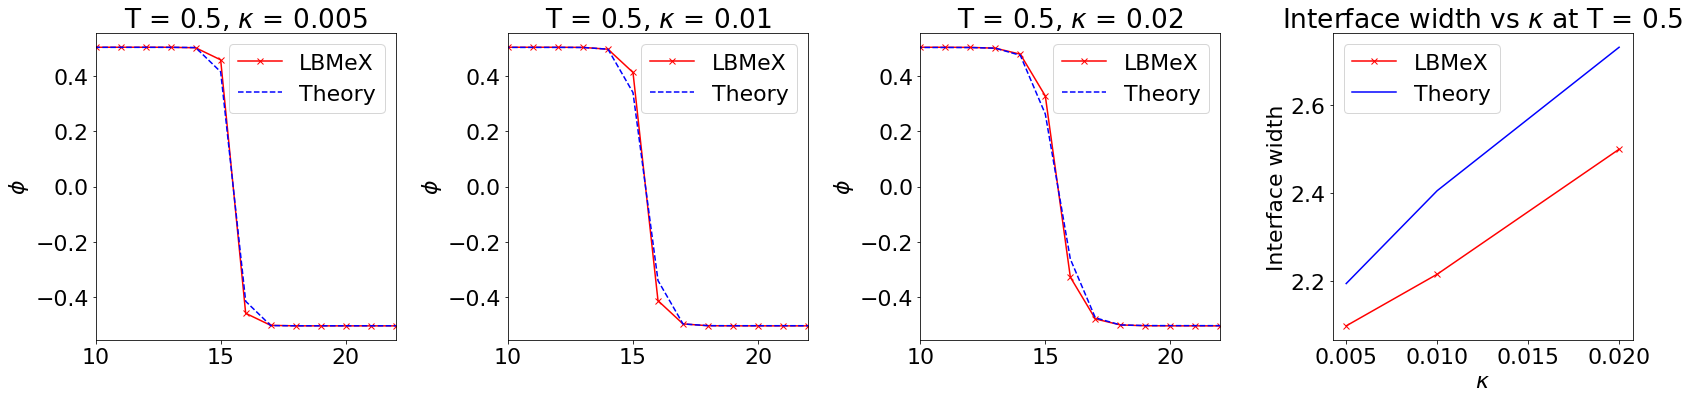

In [193]:
x, sol = profile(kappa=0.01, T=0.5, L = 32)

fig, axs = plt.subplots(1, 4, figsize = (24, 6))

phi_slice_t_05 = phi_slices[:, -2]

interface_width_ls = np.zeros((n[0], 2))

for i in range(n[0]):
    x, sol = profile(kappa=kappa_ls[i], T=0.5, L = 32)
    phi = sol(x)[0]
    # print(surface_tension(kappa=kappa_ls[i], T=0.5, Lambda=1.1))
    interface_width_ls[i, 0] = interface_width(phi_slice_t_05[i])
    interface_width_ls[i, 1] = interface_width(phi)
    axs[i].plot(phi_slice_t_05[i], '-rx', label = 'LBMeX')
    axs[i].plot(np.flip(phi), '--b', label = 'Theory')
    axs[i].set(title = 'T = 0.5, $\kappa$ = ' + str(kappa_ls[i]), ylabel = '$\phi$', xlim = (10, 22))
    axs[i].legend()
    
axs[-1].plot(kappa_ls, interface_width_ls[:, 0], '-rx', label = 'LBMeX')
axs[-1].plot(kappa_ls, interface_width_ls[:, 1], '-b', label = 'Theory') 
axs[-1].set(xlabel = r'$\kappa$', ylabel = 'Interface width', title = r'Interface width vs $\kappa$ at T = 0.5')
axs[-1].legend()


fig.tight_layout()
fig.savefig(i_w_dir + '/i_w_theory_vs_sim.png')

### Surface Tension

From Swift et al. the surface tension has two regimes. The first is at or $T_f = T_c$ and the other is $T_f > T_c$. In the former regime, the scaling of the surface tension, $\sigma$, is $\sigma \propto t^{-0.25}$ and in the latter regime, the scale of the surface tension is $\sigma \propto t^{-0.5}$ from measurement with time. These agree with the theoretical measurement from the nonequilibrium surface tension calculation, 

$$\sigma \propto \int { (\frac{\delta \Delta n}{\delta z})^2 dz}$$

In [368]:
# import h5py
# import numpy as np

# with h5py.File('plt00000.h5', "r") as f:
#     # print("Keys: %s" % f.keys())
#     a_group_keys = list(f.keys())
#     print(a_group_keys)
#     # # print(a_group_key)
#     # data = f[a_group_key]
#     data = f[a_group_keys[1]]
#     test = list(data.keys())
#     print(test)
#     ls_all_data = [data[i][()] for i in test]
#     # test_l1 = data[test[2]][()]
#     # print(test_l1.size)

# # dir(data)
# # data.keys()
# # list(data)

In [369]:
# reshape_test = test_l1.reshape(32, 32, 32, 6)

# plt.imshow(reshape_test[:, :, 32//2, 1])
# ls_all_data, test

In [370]:
# ts = yt.load('/home/nikhil/Documents/LBMeX/amrex-tutorials/GuidedTutorials/LBM/binary/surface_tension/T_0.450/R_0.200/plt*')
# ds = ts[-1]
# ad = ds.all_data()
# ds_slice = ds.r[:, 0.5, 0.5]
# yt.SlicePlot(ds, 'z', ['rho'])

In [371]:
# slice_z = ds.r[0.5, 0.5, :]['phi']
# slice_z
# dir(ds)
# test_obj = ds.slice('z', 0.5)
# pt = ds.r[(10.0, "km"), (200, "m"), (1.0, "km")]
# yt.ProfilePlot(test_obj, ('phi'), ('phi'))
# yt.LinePlot(ds, ['phi'], (0, 0, 0), (0, 0, 1), 64)

In [16]:
T_s = np.array([0.45, 0.475, 0.5, 0.525])

R_s = np.linspace(0.15, 0.4, 6)

k_s = np.array([0.02])

nsteps = 20000
nx = 64
plot_int = 1000
parent_dir = os.getcwd()


for idx, k in enumerate(k_s):
    for i, T in enumerate(T_s):
        for j, R in enumerate(R_s):
            file_out = parent_dir+ '/surface_tension/kappa_{2:.3f}/T_{0:.3f}/R_{1:.3f}'.format(T, R, k)

            try:
                os.makedirs(file_out)
            except FileExistsError:
                print('folder exists')

            os.system('cp main3d.gnu.MPI.ex {0}'.format(file_out))
            os.chdir(file_out)
            # print(os.getcwd())

            input_str = 'mpirun -n 6 ./main3d.gnu.MPI.ex nx={0} nsteps={1} plot_int={2} T={3:.3f} Rd={4:.3f}'.format(nx, nsteps, plot_int, T, R)

            with open('run.sh', 'w') as f:
                f.write('#!/bin/bash' + '\n')
                f.write(input_str)

            os.system('chmod 777 run.sh')

            # input_ls = input_str.split()
            # process = Popen(input_ls, stdout=PIPE, stderr=PIPE)
            # stdout, stderr = process.communicate()
            # print(stdout)
            # print(input_str)

            os.chdir(parent_dir)

In [17]:
run_script = '''#!/bin/bash

for i in $(find -name "R_*"); 
do
    echo "$i"
    cd ${i}
    ./run.sh
    cd ..
    echo ${PWD}
done
'''
for j, k in enumerate(k_s):
    for i, T in enumerate(T_s):
        output_file = parent_dir + '/surface_tension/kappa_{1:.3f}/T_{0:.3f}'.format(T, k)
        with open(output_file + '/sigma_script.sh', 'w') as f:
            f.write(run_script)

        os.system('chmod 777 ' + output_file + '/sigma_script.sh')

Go to the folder that points to `parent_dir + '/surface_tension/T*` variable in the code snippet above and run `./ sigma_script.sh`. Proceed with the rest of the script after this.

In [224]:
timesteps = np.linspace(0, 20000, 21)

surface_tension_dir = '/home/nikhil/Documents/LBMeX/amrex-tutorials/GuidedTutorials/LBM/binary/surface_tension/'

kappa_paths = sorted(glob.glob(surface_tension_dir + '/k*'))
T_paths = sorted(glob.glob(kappa_paths[0] + '/T*'))
R_paths = sorted(glob.glob(T_paths[0] + '/R*'))

dp_s_tension = np.zeros((len(kappa_paths), len(T_paths), len(R_paths)))
phi_s_tension = np.zeros((len(kappa_paths), len(T_paths), len(R_paths), 64))
radius_tension = np.zeros((len(kappa_paths), len(T_paths), len(R_paths), 21))

kappa_ls = np.zeros(len(kappa_paths))
T_s = np.zeros(len(kappa_paths), dtype = object)
R_s = np.zeros((len(kappa_paths), len(R_paths)), dtype = object)

for i in range(len(kappa_paths)):
    kappa_ls[i] = kappa_paths[i].split('/')[-1].split('_')[-1]
    T_paths = sorted(glob.glob(kappa_paths[i] + '/T*'))
    
    temp_T = []
    
    for j in range(len(T_paths)):
        temp_T.append(T_paths[j].split('/')[-1].split('_')[-1])
        R_paths = sorted(glob.glob(T_paths[j] + '/R*'))
        
        temp_R = []
        
        for k in range(len(R_paths)):
            temp_R.append(R_paths[k].split('/')[-1].split('_')[-1])
            
            try:
                ts = yt.load(R_paths[k] + '/plt*')
            except FileNotFoundError:
                continue
            
            for l, ds in enumerate(ts):
                radius_tension[i, j, k, l] = droplet_radius(ds) 
                
            center_p = ds.r[0.5, 0.5, 0.5]['p_bulk'] #reads center of the pressure field
            edge_p = ds.r[0, 0, 0]['p_bulk'] #reads edge of the pressur field
            dp_s_tension[i, j, k] = center_p - edge_p
            
            slice_z = ds.r[0.5, 0.5, :]['phi'] # slices system through z direction at x = y = 0.5, center of the droplet through the axis
            phi_s_tension[i, j, k] = slice_z
        
        R_s[i, j] = temp_R
    
    T_s[i] = temp_T

In [ ]:
# yt.LinePlot(ts, 'phi', (0.5, 0.5, 0), (0.5, 0.5, 1), 64)

In [141]:
# rho = ts[-1].r['boxlib', 'phi']
# rho['x']
# dd = ts[-1].all_data()
# test = ts[-1].r[0.5, 0.5, 0.5]
# test
# plt.imshow(test[:, 32, :])
ds.field_list
print(ds.field_info[('boxlib', 'phi')].nodal_flag)
# print(ds.all_data()[('boxlib', 'phi')].shape)

[0, 0, 0]


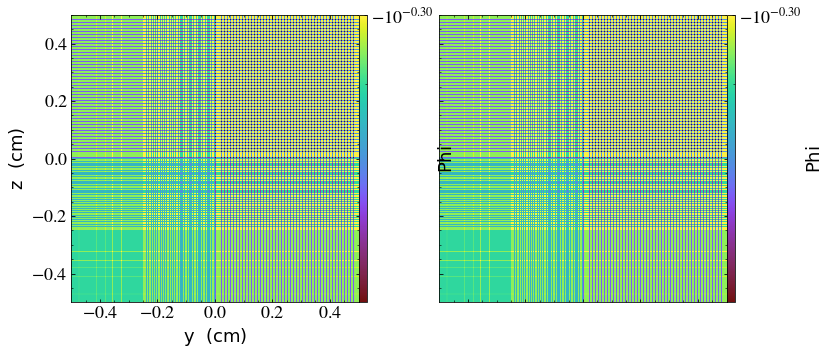

In [4]:
#binary_droplet/plt?????



ts = yt.load('plt?????')
ds = ts[-1]
p1 = yt.SlicePlot(ds, 0, ('boxlib','phi'))

ts = yt.load('plt?????')
ds = ts[-1]
p2 = yt.SlicePlot(ds, 0, ('boxlib','phi'))

from mpl_toolkits.axes_grid1 import AxesGrid

fig = plt.figure()

# See http://matplotlib.org/mpl_toolkits/axes_grid/api/axes_grid_api.html
# These choices of keyword arguments produce a four panel plot that includes
# four narrow colorbars, one for each plot.  Axes labels are only drawn on the
# bottom left hand plot to avoid repeating information and make the plot less
# cluttered.
grid = AxesGrid(
    fig,
    (0.075, 0.075, 0.85, 0.85),
    nrows_ncols=(1, 2),
    axes_pad=1.0,
    label_mode="1",
    share_all=True,
    cbar_location="right",
    cbar_mode="each",
    cbar_size="3%",
    cbar_pad="0%",
)

for i, p in enumerate([p1,p2]):
    pl = p.plots[('boxlib','phi')]
    pl.figure = fig
    pl.axes = grid[i].axes
    pl.cax = grid.cbar_axes[i]
    p._setup_plots()

#plt.savefig("binary.png")
plt.show()